In [3]:
pip install statsmodels

  Using cached statsmodels-0.14.5-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached statsmodels-0.14.5-cp313-cp313-win_amd64.whl (9.6 MB)
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)

   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmod

/n전처리 완료. 분석 대상 데이터 수: 3983956
/n==================================================
[가설 1] 주말에는 평일보다 이용 시간이 더 길 것이다.
평일 평균 이용시간: 20.86분
주말 평균 이용시간: 25.00분
T-statistic: 134.57, P-value: 0.00000
>> 결과: 가설 채택. 주말과 평일의 이용 시간은 통계적으로 유의미한 차이가 있습니다.


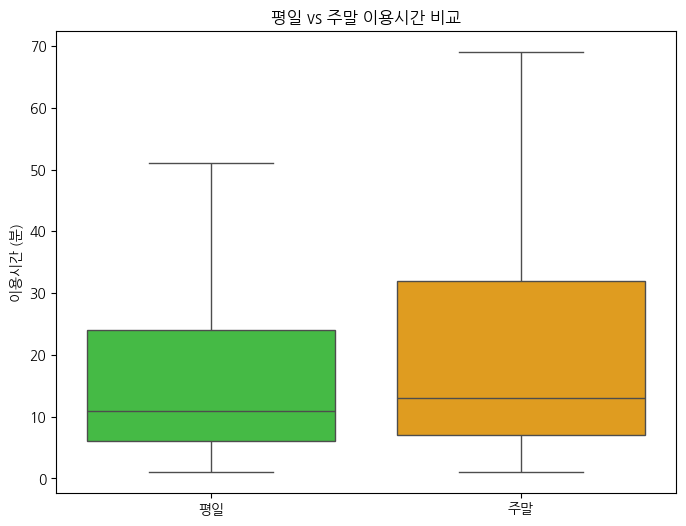

In [4]:
import pandas as pd
import numpy as np
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
path = r"C:\Users\diyou\Downloads\서울특별시 공공자전거 대여이력 정보_2506.csv"
chunks = pd.read_csv(path, encoding="cp949", chunksize=100000)
df_list = []
for chunk in chunks:
    df_list.append(chunk[['대여일시', '이용시간(분)', '이용거리(M)']])

df = pd.concat(df_list, ignore_index=True)
col_date = '대여일시'
col_time = '이용시간(분)'
col_dist = '이용거리(M)'
df[col_date] = pd.to_datetime(df[col_date])
df['weekday_num'] = df[col_date].dt.weekday
df['is_weekend'] = df['weekday_num'] >= 5  # 토(5), 일(6)이면 주말
df['hour'] = df[col_date].dt.hour
def get_time_group(h):
    if 7 <= h <= 9:
        return '출근(07-09)'
    elif 17 <= h <= 20: # 퇴근 시간을 조금 넓게 잡음
        return '퇴근(17-20)'
    elif 10 <= h <= 16:
        return '주간(10-16)'
    else:
        return '기타(야간/새벽)'
df['time_group'] = df['hour'].apply(get_time_group)
df_clean = df[(df[col_time] > 0) & (df[col_dist] > 0)].copy()
print("/n전처리 완료. 분석 대상 데이터 수:", len(df_clean))

print("/n" + "="*50)
print("[가설 1] 주말에는 평일보다 이용 시간이 더 길 것이다.")
print("="*50)

group_weekday = df_clean[df_clean['is_weekend'] == False][col_time]
group_weekend = df_clean[df_clean['is_weekend'] == True][col_time]
t_stat, p_val = stats.ttest_ind(group_weekend, group_weekday)

print(f"평일 평균 이용시간: {group_weekday.mean():.2f}분")
print(f"주말 평균 이용시간: {group_weekend.mean():.2f}분")
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.5f}")
if p_val < 0.05:
    print(">> 결과: 가설 채택. 주말과 평일의 이용 시간은 통계적으로 유의미한 차이가 있습니다.")
else:
    print(">> 결과: 가설 기각. 차이가 없습니다.")    #"P < 0.001" 
plt.figure(figsize=(8, 6))
df_sample = df_clean.sample(n=50000, random_state=42)
df_weekday = df_sample[df_sample['is_weekend'] == False]
df_weekend = df_sample[df_sample['is_weekend'] == True]
sns.boxplot(x=[0]*len(df_weekday), y=df_weekday['이용시간(분)'], color='limegreen', showfliers=False)
sns.boxplot(x=[1]*len(df_weekend), y=df_weekend['이용시간(분)'], color='orange', showfliers=False)
plt.xticks([0, 1], ['평일', '주말'])
plt.title('평일 vs 주말 이용시간 비교')
plt.ylabel('이용시간 (분)')
plt.show()

/n==================================================
[가설 2] 출근, 주간, 퇴근 시간대의 평균 이동거리는 모두 같다.
F-statistic: 18777.82, P-value: 0.00000
>> 결과: 가설 기각. 적어도 한 시간대 그룹 간 이동거리 차이가 있습니다.
/n[사후 검정 결과]
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj   lower     upper   reject
--------------------------------------------------------------
주간(10-16) 출근(07-09) -433.8786   0.0 -444.9424 -422.8148   True
주간(10-16) 퇴근(17-20)  457.9168   0.0   448.715  467.1186   True
출근(07-09) 퇴근(17-20)  891.7954   0.0  880.7482  902.8426   True
--------------------------------------------------------------


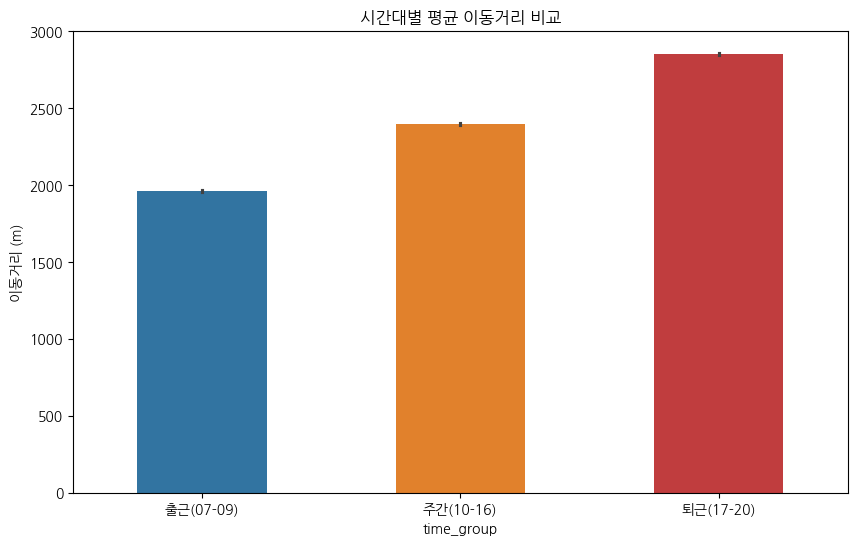

In [3]:
print("/n" + "="*50)
print("[가설 2] 출근, 주간, 퇴근 시간대의 평균 이동거리는 모두 같다.")
print("="*50)
groups = ['출근(07-09)', '주간(10-16)', '퇴근(17-20)']
data_groups = [df_clean[df_clean['time_group'] == g][col_dist] for g in groups]
f_stat, p_val_anova = stats.f_oneway(*data_groups)

print(f"F-statistic: {f_stat:.2f}, P-value: {p_val_anova:.5f}")   

if p_val_anova < 0.05:
    print(">> 결과: 가설 기각. 적어도 한 시간대 그룹 간 이동거리 차이가 있습니다.")   #"P < 0.001" 
    subset = df_clean[df_clean['time_group'].isin(groups)]
    tukey = pairwise_tukeyhsd(endog=subset[col_dist], groups=subset['time_group'], alpha=0.05)
    print("/n[사후 검정 결과]")
    print(tukey)
else:
    print(">> 결과: 시간대별 이동거리 차이가 없습니다.")
plt.figure(figsize=(10, 6))
colors=['#1f77b4', '#ff7f0e', '#d62728']
sns.barplot(x='time_group', y=col_dist, data=subset, hue='time_group',dodge=False,order=groups, palette=colors,errorbar=('ci', 95),width=0.5,legend=False) # ci=95: 95% 신뢰구간 표시
plt.title('시간대별 평균 이동거리 비교')
plt.ylabel('이동거리 (m)')
plt.show()

/n==================================================
[가설 3] 이동거리가 멀수록 이용시간도 비례해서 늘어날 것이다.
피어슨 상관계수(r): 0.6180
P-value: 0.00000
>> 해석: 뚜렷한 양의 상관관계가 있습니다.


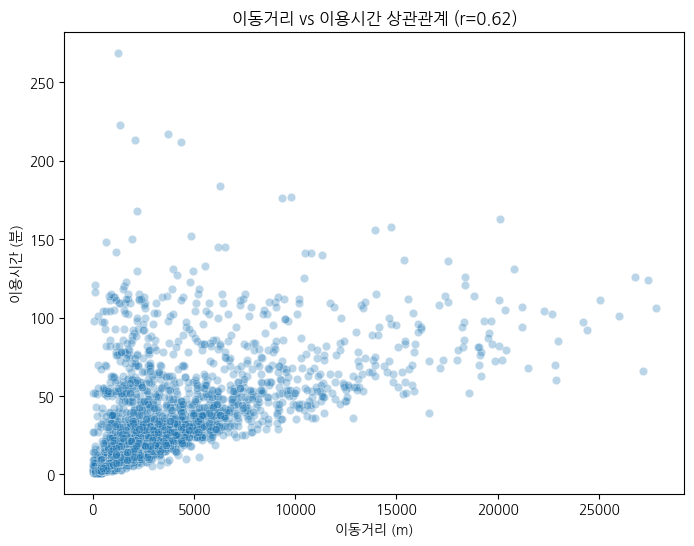

In [34]:
print("/n" + "="*50)
print("[가설 3] 이동거리가 멀수록 이용시간도 비례해서 늘어날 것이다.")
print("="*50)
corr, p_val_corr = stats.pearsonr(df_clean[col_dist], df_clean[col_time])

print(f"피어슨 상관계수(r): {corr:.4f}")
print(f"P-value: {p_val_corr:.5f}")  #P < 0.001

if abs(corr) > 0.7:
    print(">> 해석: 매우 강한 양의 상관관계가 있습니다.")
elif abs(corr) > 0.3:
    print(">> 해석: 뚜렷한 양의 상관관계가 있습니다.")
else:
    print(">> 해석: 상관관계가 약하거나 거의 없습니다.")

sample_df = df_clean.sample(n=min(5000, len(df_clean)), random_state=42) # 5000개만 샘플링
plt.figure(figsize=(8, 6))
sns.scatterplot(x=col_dist, y=col_time, data=sample_df, alpha=0.3)
plt.title(f'이동거리 vs 이용시간 상관관계 (r={corr:.2f})')
plt.xlabel('이동거리 (m)')
plt.ylabel('이용시간 (분)')
plt.show()